<a href="https://colab.research.google.com/github/ghinaalamsyahh/Steam-Store-2024-Hot-Picks-and-Reviews/blob/main/Steam_Store_2024_Hot_Picks_and_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Trend, Sentiment, and Market Analysis about Steam Store 2024: Hot Picks and Reviews**

**Created by: Ghina Hanifah Alamsyah**

In [90]:
# Import all the libraries required
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv(r'/content/sample_data/steam_store_data_2024.csv') # dataset

In [91]:
# Generate informations from the data
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           86 non-null     object
 1   description     82 non-null     object
 2   price           61 non-null     object
 3   salePercentage  59 non-null     object
 4   recentReviews   57 non-null     object
 5   allReviews      57 non-null     object
dtypes: object(6)
memory usage: 4.2+ KB


In [92]:
# Change the price and the percentage to number format
# Remove '$' from the 'price' column and convert to numeric
if 'price' in data.columns:
    data['price'] = data['price'].astype(str).str.replace('$', '', regex=False)

# Check if the column is string (object) and contains '%', convert only those rows
def convert_percent(val):
    if isinstance(val, str) and '%' in val:
        return float(val.rstrip('%')) / 100 # Change them to decimals without decreasing the values everytime the code get a reran
    return val

# Convert percentage strings into float values
data['salePercentage'] = data['salePercentage'].apply(convert_percent)

# Display the first 5 rows from the dataset
display(data.head())

,title,description,price,salePercentage,recentReviews,allReviews
0,Ori and the Will of the Wisps,Play the critically acclaimed masterpiece. Emb...,9.89,-0.67,Overwhelmingly Positive,Overwhelmingly Positive
1,"Flashing Lights - Police, Firefighting, Emerge...",Play solo or in up to 10-player multiplayer co...,8.49,-0.66,Very Positive,Very Positive
2,Thronefall,A minimalist game about building and defending...,5.24,-0.25,Overwhelmingly Positive,Overwhelmingly Positive
3,DRAGON QUEST® XI S: Echoes of an Elusive Age™ ...,The Definitive Edition includes the critically...,23.99,-0.40,Very Positive,Very Positive
4,UNDYING,"As Anling’s zombie infection sets in, her days...",13.99,-0.30,Mostly Positive,Mostly Positive


As we can see, the price and salePercentage values has changed into decimals and no longer have units. This will be very useful to make a correlation, plots, linear regression, accuracy, and KNN value later.

In [93]:
# Make a dataframe
df = pd.DataFrame(data)

In [94]:
# Data Cleaning
import re # Regular Expression/RegEx, which is part of NLP (Natural Language Processing)
from wordcloud import STOPWORDS

# Combine all the descriptions into one string
text = ' '.join(df['description'].astype(str).tolist())

# Remove all non-alphabetic characters from the descriptions
text = re.sub(r'[^A-Za-z\s]', '', text)

# Make all the texts smaller (no capitals)
text = text.lower()

# Remove stopwords (such as 'a', 'the', 'is')
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

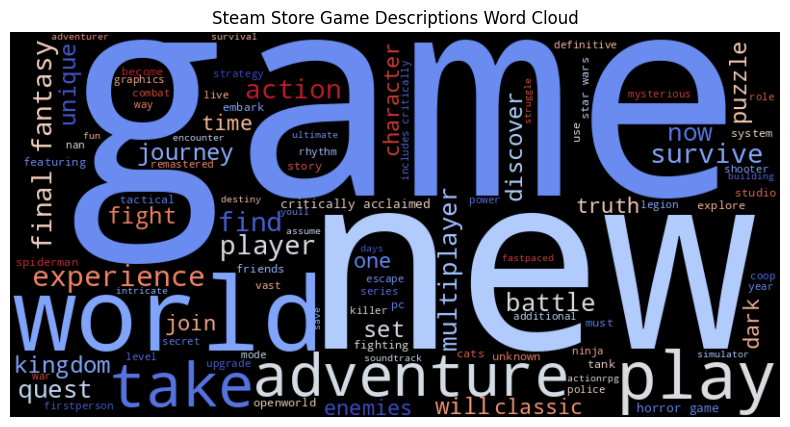

In [95]:
# Import WordCloud library
from wordcloud import WordCloud

# Generate the most used words from the descriptions, set the background color as black and texts with 'coolwarm' color tone using WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=100, colormap='coolwarm').generate(text)

# Plot the result
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # No axis
plt.title("Steam Store Game Descriptions Word Cloud")
plt.show()

We can conclude that the most common words here are: game, new, world, experience, play, action, adventure, player, take, and survive. By eliminating some words, it means a lot of the games are possibly categorized into 'Adventure', 'Action', and 'Survival' genre.

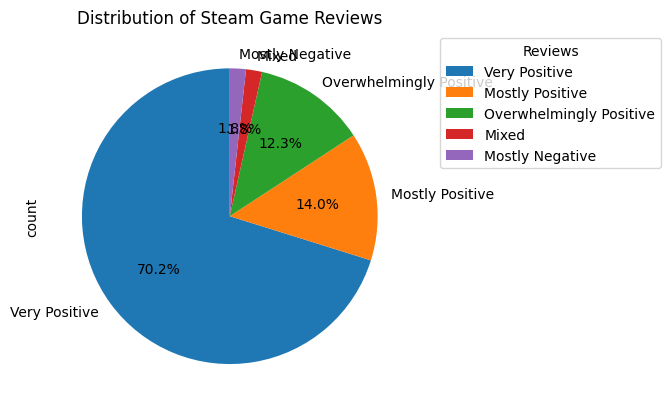

In [96]:
# Make a review distribution in a pie chart
df['allReviews'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.legend(title="Reviews", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Distribution of Steam Game Reviews")
plt.show()

Based on the chart, most games on Steam in 2024 were dominated by "Very Positive" reviews, approximately about 70.2%.

In [97]:
# Define gaming categories and keywords (to categorize the games by detecting the keywords)
# gaming_levels contains the genres, and gaming_keywords contains the keywords data from 'descriptions' label
gaming_levels = ["action", "action", "action", "action", "action", "action", "adventure",
                   "adventure", "adventure", "puzzle", "puzzle", "rpg", "rpg", "simulator", "simulation",
                   "strategy", "strategy", "sports", "rhythm", "action rpg", "action rpg", "action rpg", "rpg", "survival", "survival", "action-adventure"]
gaming_keywords = ["action", "shooter", "fighting", "fight", "survival", "horror", "adventure",
                     "adventurer", "adventures", "puzzle", "puzzles", "role", "rpg", "simulator", "simulation",
                     "strategy", "tactical", "sports", "rhythm", "action rpg", "actionrpg", "action-RPG", "final fantasy", "surviving", "survive", "action-adventure"]

# Create an empty 'category' column in the DataFrame
df['category'] = None

# TF-IDF Process (Term Frequency-Inverse Document Frequency), which is part of NLP (Natural Language Processing)
# TF = Measures how often a word appears in a document
# IDF = Reduces the weight of common words while increasing the weight of rare words
# import TF-IDF libraries from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize and fit TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(df['description'].astype(str))

# Get the feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Iterate through keywords and assign categories
for i, keyword in enumerate(gaming_keywords):
    if keyword in feature_names:
        # Get the index of the keyword in the feature names
        keyword_index = vectorizer.vocabulary_.get(keyword)

        # Find the rows where the keyword is present in the TF-IDF features
        # tfidf_features is a sparse matrix, so check for non-zero values at the keyword index
        if keyword_index is not None:
            # Check for non-zero values at the keyword index
            keyword_present_indices = tfidf_features[:, keyword_index].nonzero()[0]

            # Assign the corresponding category to the rows where the keyword is present
            df.loc[keyword_present_indices, 'category'] = gaming_levels[i]

# Assign 'action' category to 'Mixed' and 'Mostly Negative' reviews
# This is intentional, because the words “action” and “adventure” are often used in a generic sense,
# Since some games can be difficult to predict by specific keywords because lack of the descriptions
# Not necessarily indicating a specific game genre, while the other keywords are more indicative of the game category.
df.loc[df['allReviews'].isin(["Mixed", "Mostly Negative"]), 'category'] = "action"

# Label games with "FINAL FANTASY" in title or description as "rpg"
df.loc[df['title'].astype(str).str.contains('FINAL FANTASY', case=False, na=False) |
       df['description'].astype(str).str.contains('FINAL FANTASY', case=False, na=False), 'category'] = 'rpg'

display(df)

,title,description,price,salePercentage,recentReviews,allReviews,category
0,Ori and the Will of the Wisps,Play the critically acclaimed masterpiece. Emb...,9.89,-0.67,Overwhelmingly Positive,Overwhelmingly Positive,puzzle
1,"Flashing Lights - Police, Firefighting, Emerge...",Play solo or in up to 10-player multiplayer co...,8.49,-0.66,Very Positive,Very Positive,simulator
2,Thronefall,A minimalist game about building and defending...,5.24,-0.25,Overwhelmingly Positive,Overwhelmingly Positive,None
3,DRAGON QUEST® XI S: Echoes of an Elusive Age™ ...,The Definitive Edition includes the critically...,23.99,-0.40,Very Positive,Very Positive,adventure
4,UNDYING,"As Anling’s zombie infection sets in, her days...",13.99,-0.30,Mostly Positive,Mostly Positive,survival
...,...,...,...,...,...,...,...
81,Bendy and the Dark Revival,Bendy and the Dark Revival® is a first-person ...,5.99,-0.80,Very Positive,Very Positive,survival
82,STAR WARS™ - The Force Unleashed™ Ultimate Sit...,"A game that will show gamers the deepest, dark...",6.99,-0.65,Very Positive,Very Positive,None
83,Thymesia,Thymesia is a gruelling action-RPG with fast-p...,14.99,-0.40,Very Positive,Very Positive,rpg
84,Last Train Home,The Great War is over - the fight continues. C...,26.39,-0.34,Very Positive,Very Positive,survival


The genres or basically 'category' label and rows has been added, now we can see what kind of games they are. Some of the games may have 'None' due to lack of informations that related to certain genres from the 'descriptions'.

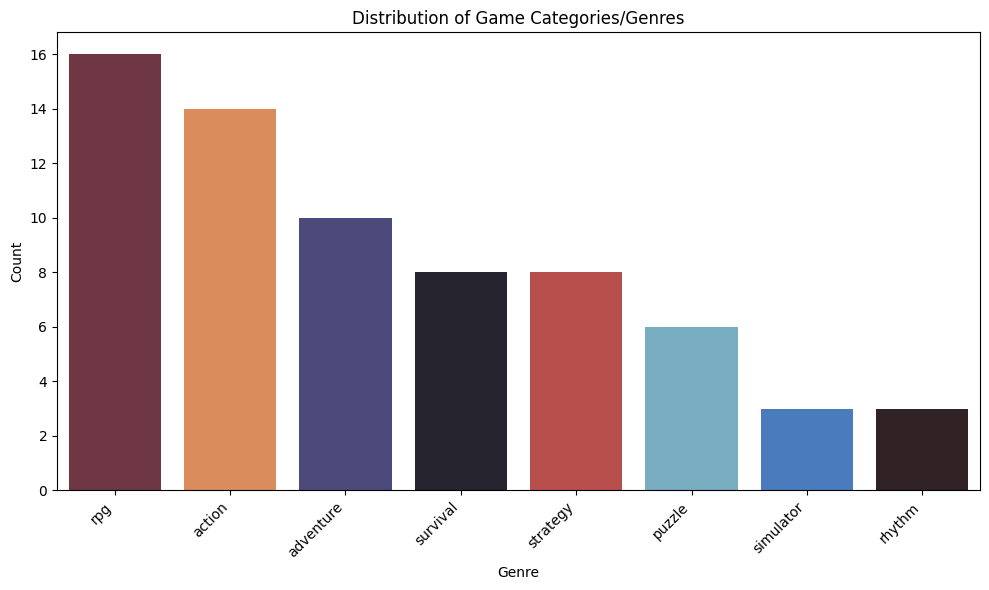

In [98]:
# Import seaborn and matplotlib library
import seaborn as sns
import matplotlib.pyplot as plt

# Make a plot about the distribution of game based on their genres
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index, palette='icefire', hue='category', legend=False)
plt.title("Distribution of Game Categories/Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

So, top 3 most common game genres in 2024 are: RPG, Action, Adventure

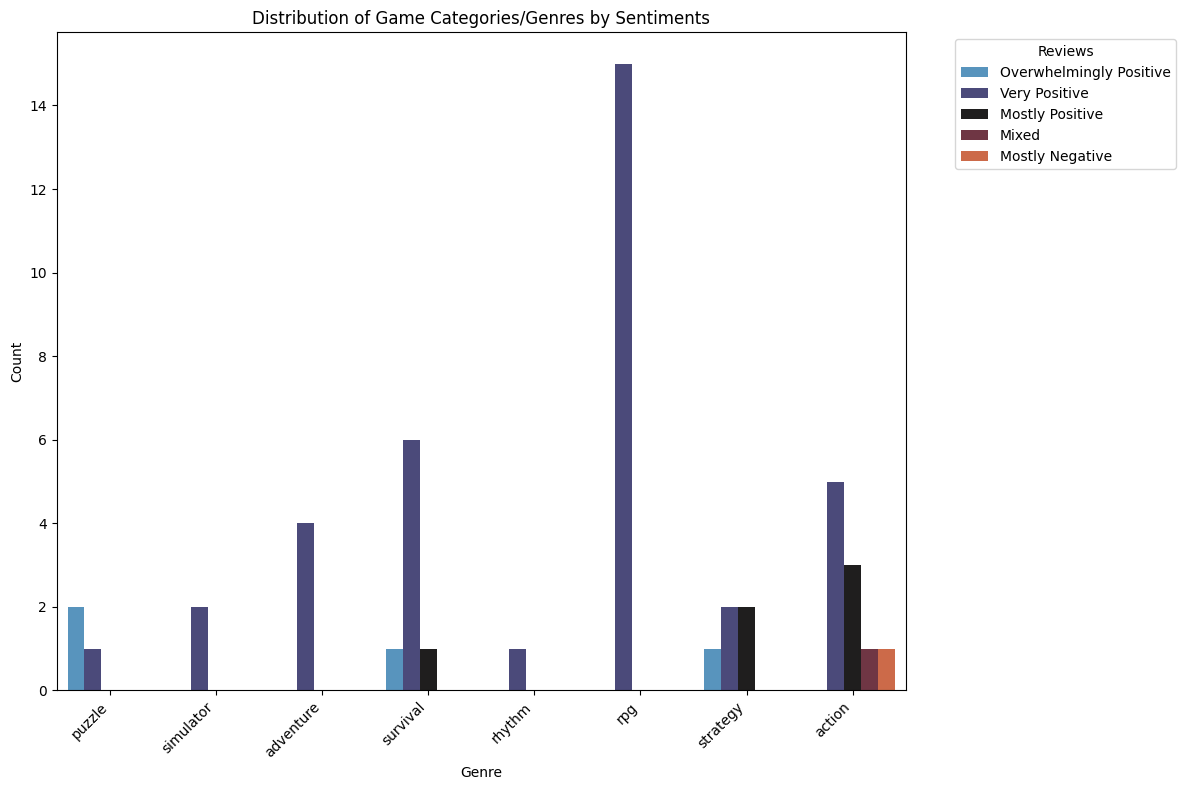

/tmp/ipython-input-99-2104830098.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Reviews", bbox_to_anchor=(1.05, 1), loc='upper left')


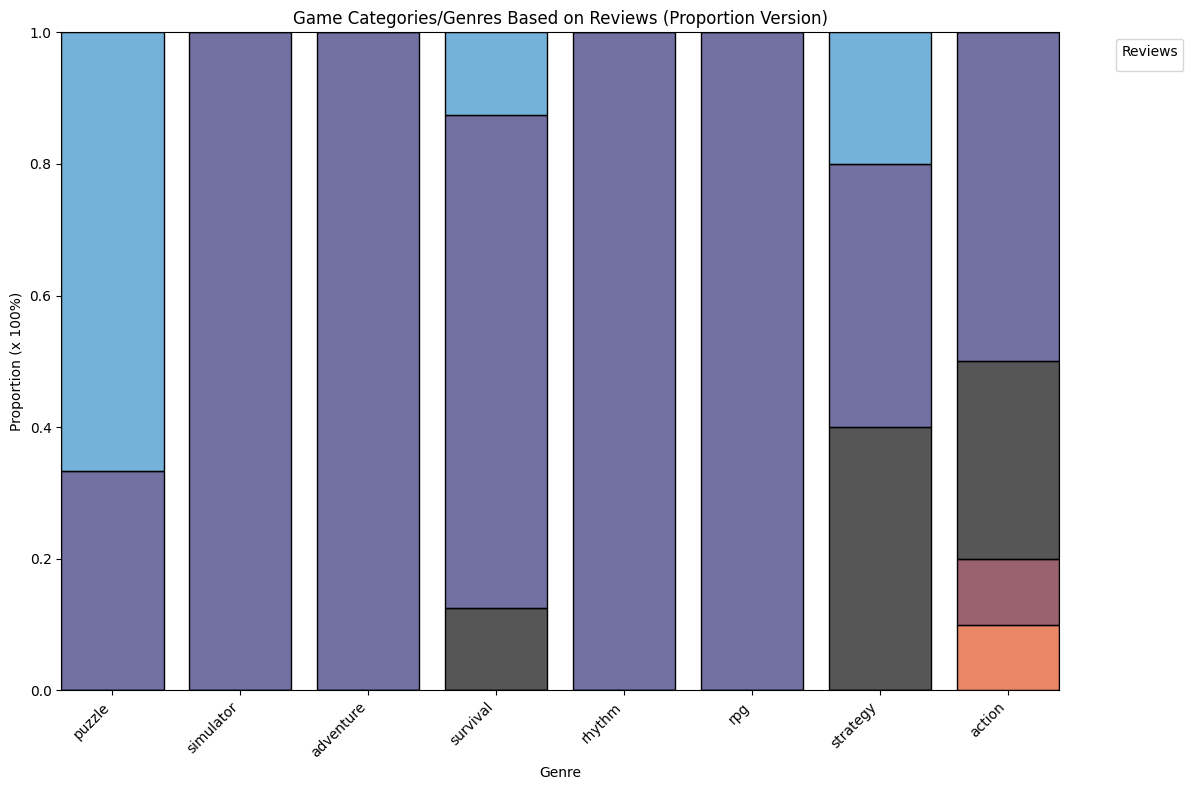

In [99]:
# Make a plot which contains the distribution of the reviews/sentiment based on the genres

# Filter out rows where category or allReviews is None with df.dropna
plt.figure(figsize=(12, 8))
df_filtered = df.dropna(subset=['category', 'allReviews'])
sns.countplot(data=df_filtered, x='category', hue='allReviews', palette='icefire')
plt.title("Distribution of Game Categories/Genres by Sentiments")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Reviews", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Make the plot with similar data but in proportional version
plt.figure(figsize=(12, 8))
sns.histplot(data=df_filtered, x='category', hue='allReviews', palette='icefire', multiple="fill", shrink=.8)
plt.title("Game Categories/Genres Based on Reviews (Proportion Version)")
plt.xlabel("Genre")
plt.ylabel("Proportion (x 100%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Reviews", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- 'RPG' games got the most "Very Positive" reviews, followed by 'Survival' and 'Action'
- 'Puzzle' games got the most "Overwhelmingly Positive", followed by 'Survival' and 'Strategy'
- 'Action' games has the most "Very Positive", "Mixed", and "Mostly Negative" at the same time


In [100]:
# Show the games that received mostly negative, mixed, and overwhelmingly positive reviews
# List all the keywords
keyword = ('Mostly Negative', 'Mixed', "Overwhelmingly Positive")
# Create a regex pattern from the tuple of keywords
pattern = '|'.join(keyword)

# Search in 'allReviews' or 'recentReviews' using the regex pattern
filtered_df1 = df[df['allReviews'].str.contains(pattern, case=False, na=False) |
                                   df['recentReviews'].str.contains(pattern, case=False, na=False)]
# Print
filtered_df1

,title,description,price,salePercentage,recentReviews,allReviews,category
0,Ori and the Will of the Wisps,Play the critically acclaimed masterpiece. Emb...,9.89,-0.67,Overwhelmingly Positive,Overwhelmingly Positive,puzzle
2,Thronefall,A minimalist game about building and defending...,5.24,-0.25,Overwhelmingly Positive,Overwhelmingly Positive,None
51,God of War,His vengeance against the Gods of Olympus year...,24.99,-0.50,Overwhelmingly Positive,Overwhelmingly Positive,survival
58,Ori and the Will of the Wisps,Play the critically acclaimed masterpiece. Emb...,9.89,-0.67,Overwhelmingly Positive,Overwhelmingly Positive,puzzle
62,Thronefall,A minimalist game about building and defending...,5.24,-0.25,Overwhelmingly Positive,Overwhelmingly Positive,None
68,Halo Infinite (Campaign),NaN,23.99,-0.60,Mixed,Mixed,action
72,STAR WARS™ Empire at War - Gold Pack,Command or corrupt an entire galaxy in the def...,6.99,-0.65,Overwhelmingly Positive,Overwhelmingly Positive,strategy
76,Destiny 2: Lightfall + Annual Pass,NaN,33.00,-0.67,Mostly Negative,Mostly Negative,action
80,LEGO® Star Wars™ - The Complete Saga,Kick Some Brick in I through VI! Play through ...,4.99,-0.75,Overwhelmingly Positive,Overwhelmingly Positive,None


- Mostly Negative perceived games: Destiny 2: Lightfall + Annual Pass
- Mixed perceived games: Halo Infinite (Campaign)
- Overwhelmingly Positive perceived games: LEGO® Star Wars™ - The Complete Saga, STAR WARS™ Empire at War - Gold Pack, Thronefall, Ori and the Will of the Wisps

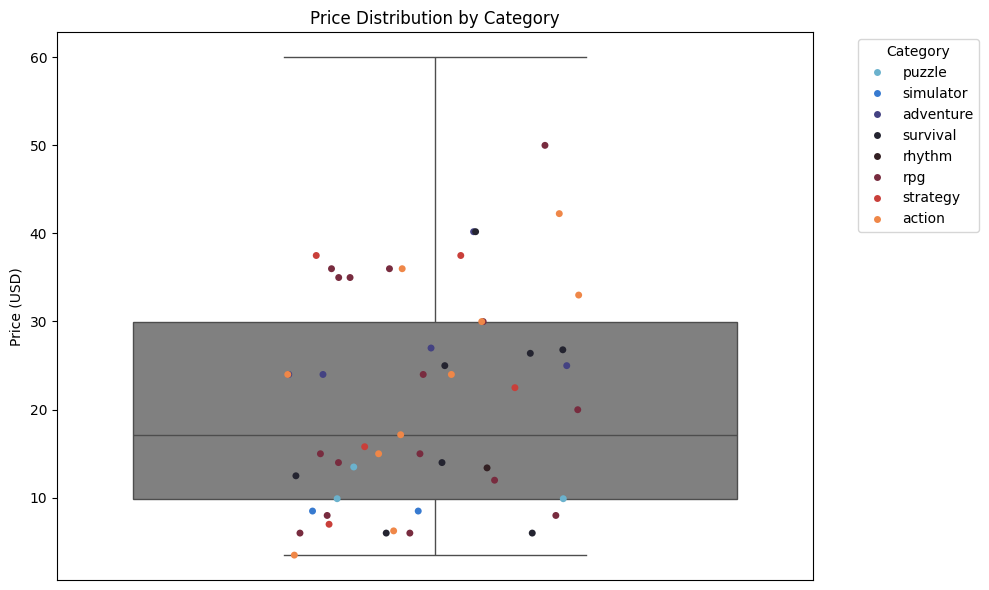

,price,salePercentage
count,61.000000,59.000000
mean,20.500984,-0.486610
std,12.955313,0.194499
min,3.490000,-0.800000
25%,9.890000,-0.655000
50%,17.150000,-0.500000
75%,29.990000,-0.335000
max,59.990000,-0.100000


In [101]:
# Ensure 'price' in data is numeric and filter
df['price'] = pd.to_numeric(df['price'], errors='coerce')
games_filtered = df[df['price'].notna() & (df['price'] >= 0)].copy()

# Create the boxplot and jitter plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=games_filtered, y='price', color="grey", x=[0]*len(games_filtered)) # Use y for horizontal boxplot and set x to 0 for centering
sns.stripplot(data=games_filtered, y='price', x=[0]*len(games_filtered), # Add jittered points and set x to 0 for centering
              hue=games_filtered['category'],
              palette='icefire',
              size=5, jitter=0.2)
plt.title("Price Distribution by Category")
plt.ylabel("Price (USD)")
plt.xticks([]) # Remove x-axis ticks
plt.xlabel("") # Remove x-axis label
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

df.describe()

- The interquartile range is between 9.89 and 29.99 USD, where the median is 17.15 USD. It means that half the prices are greater than or equal to this value, and half are less
- The most affordable games (located on lower quartile line) are 'Puzzle' games (blue dots), 'Action' games are in the middle, and both 'RPG' and certain 'Action' games are less affordable

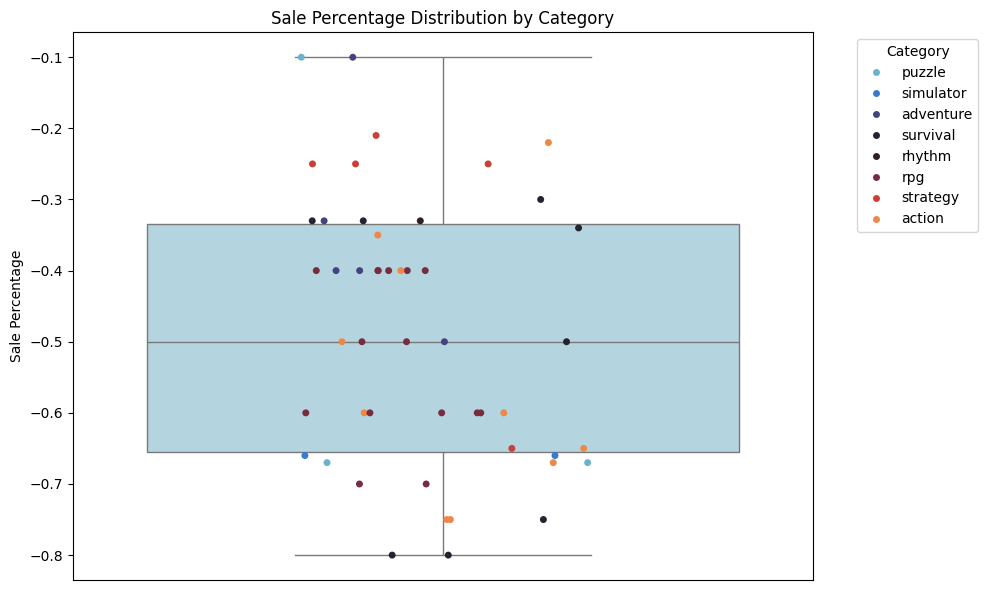

,price,salePercentage
count,61.000000,59.000000
mean,20.500984,-0.486610
std,12.955313,0.194499
min,3.490000,-0.800000
25%,9.890000,-0.655000
50%,17.150000,-0.500000
75%,29.990000,-0.335000
max,59.990000,-0.100000


In [102]:
# Assuming 'data' is your DataFrame with 'salePercentage' and 'df' has 'category'

# Ensure 'salePercentage' in data is numeric and filter
df['salePercentage'] = pd.to_numeric(df['salePercentage'], errors='coerce')
games_filtered_sale = df[df['salePercentage'].notna()].copy()

# Create the boxplot and jitter plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=games_filtered_sale, y='salePercentage', color="lightblue", x=[0]*len(games_filtered_sale)) # Use y for horizontal boxplot and set x to 0 for centering
sns.stripplot(data=games_filtered_sale, y='salePercentage', x=[0]*len(games_filtered_sale), # Add jittered points and set x to 0 for centering
              hue=games_filtered_sale['category'],
              palette='icefire',
              size=5, jitter=0.2)
plt.title("Sale Percentage Distribution by Category")
plt.ylabel("Sale Percentage")
plt.xticks([]) # Remove x-axis ticks
plt.xlabel("") # Remove x-axis label
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

df.describe()

- The interquartile range is between -65.5% to -33.5%, with -50% as the middle point
- Those that occasionally had a higher sale (-65.5%) were 'Simulator' and 'Puzzle' games, while their original prices were relatively already cheaper
- 'RPG' games had -50% during the Steam sale period, their original prices were just in the middle/median value
- 'Survival' and 'Rhythm' games only had -33.5% sale, while their original prices were more expensive


/tmp/ipython-input-103-2972508666.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='allReviews', y='salePercentage', palette='icefire')


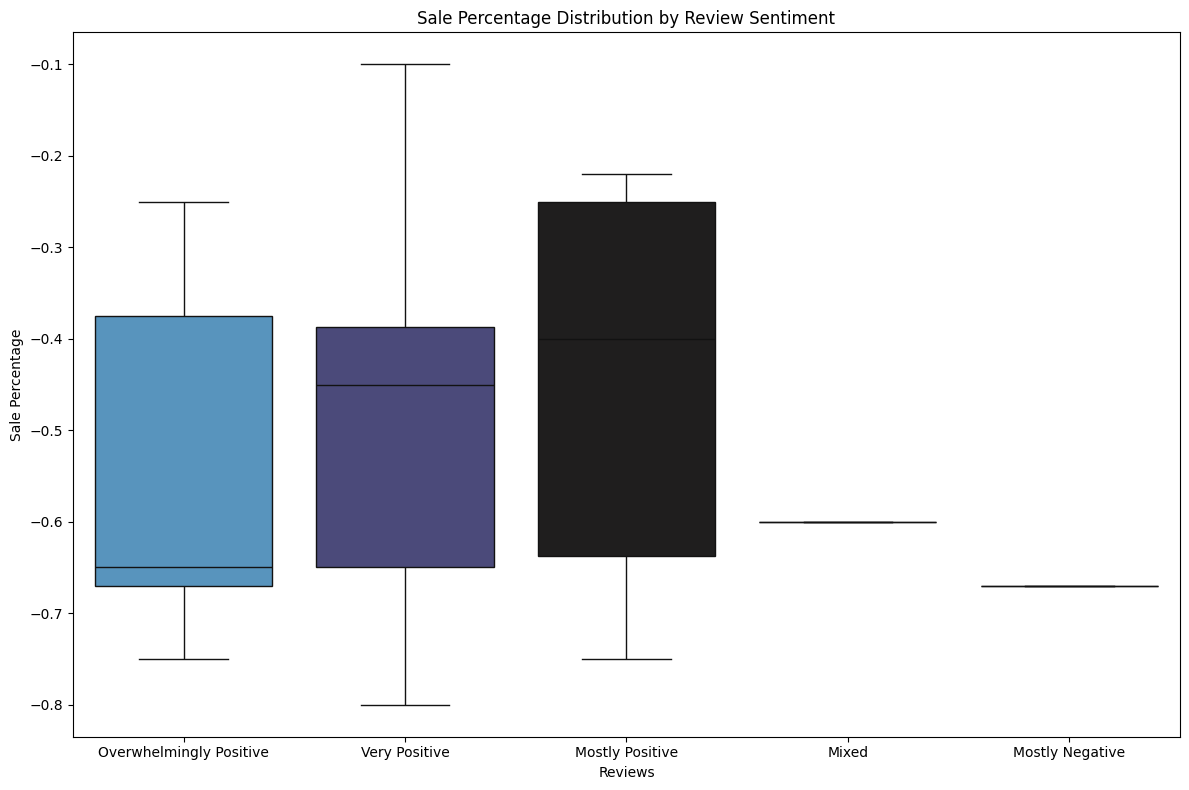

In [103]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='allReviews', y='salePercentage', palette='icefire')
plt.title('Sale Percentage Distribution by Review Sentiment')
plt.xlabel('Reviews')
plt.ylabel('Sale Percentage')
plt.tight_layout()
plt.show()

- 'Overwhelmingly Positive' and 'Mostly Negative' review games tend to get higher sale percentages, followed by 'Mixed' review games.
- We can see the pattern that 'Overwhelmingly Positive' games get higher sale, probably because it's so popular, well-liked, and highly-demanded. So, giving them higher sale percentages will attract more newcomers to play the games and increase the companies' salary.
- 'Mostly Negative' games get higher sale, possibly because it's not well-liked. So, giving them higher sale percentages will be needed to at least attract some buyers, because it'll be difficult to get more salary if the price stays too expensive.

/tmp/ipython-input-104-2562000550.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=games_filtered_sale, x='category', y='salePercentage', palette='icefire', legend=False)


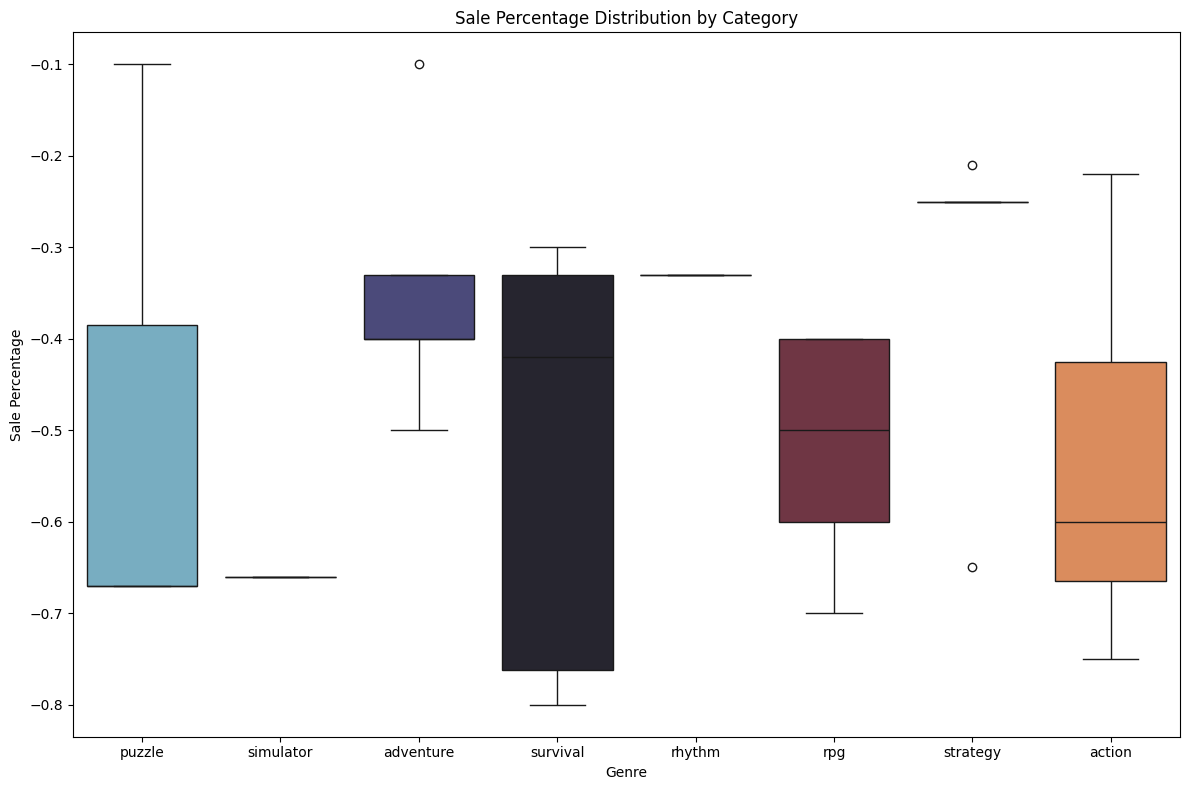

In [104]:
# Assuming 'data' is your DataFrame with 'salePercentage' and 'df' has 'category'

# Ensure 'salePercentage' in data is numeric and filter
df['salePercentage'] = pd.to_numeric(df['salePercentage'], errors='coerce')
games_filtered_sale = df[df['salePercentage'].notna()].copy()

# Merge the 'category' column from df to games_filtered_sale based on index
# games_filtered_sale = games_filtered_sale.merge(df[['category']], left_index=True, right_index=True, how='left')

plt.figure(figsize=(12, 8))
sns.boxplot(data=games_filtered_sale, x='category', y='salePercentage', palette='icefire', legend=False)
plt.title('Sale Percentage Distribution by Category')
plt.xlabel('Genre')
plt.ylabel('Sale Percentage')
plt.tight_layout()
plt.show()

- 'Puzzle' and 'Simulator' games tend to get higher discounts, followed by 'Action' games
- 'Survival' and 'Adventure' games tend to get lower discounts

In [105]:
# Import libraries
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

# Perform a linear regression analysis using KFold cross-validation to assess how well 'salePercentage' can predict 'price'
# Ensure 'price' and 'salePercentage' are numeric in the original data DataFrame
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['salePercentage'] = pd.to_numeric(df['salePercentage'], errors='coerce')

# Create a new DataFrame with only the columns needed for regression and drop rows with NaNs
# This is important because LinearRegression cannot handle NaN values
regression_df = df[['price', 'salePercentage']].dropna()

# Define features (X) and target (y) from the cleaned DataFrame
X = pd.DataFrame(regression_df['salePercentage'])
y = pd.DataFrame(regression_df['price'])

model = LinearRegression()
scores = []
# KFold is set up for 3 splits with shuffling and a fixed random state
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Check if there are enough samples for splitting after dropping NaNs
if len(regression_df) > 0:
    for i, (train, test) in enumerate(kfold.split(X, y)):
        model.fit(X.iloc[train,:], y.iloc[train,:])
        score = model.score(X.iloc[test,:], y.iloc[test,:])
        scores.append(score)
        # R-squared scores for each fold
    print("Cross-validation scores:", scores)
else:
    print("Not enough data after handling missing values to perform cross-validation.")

Cross-validation scores: [0.19928857994545168, -0.10286780350908598, 0.17807667980556796]


We can conclude that sale percentage is not a strong linear predictor of game price based on this analysis.

Correlation between sale percentage and price: 0.47


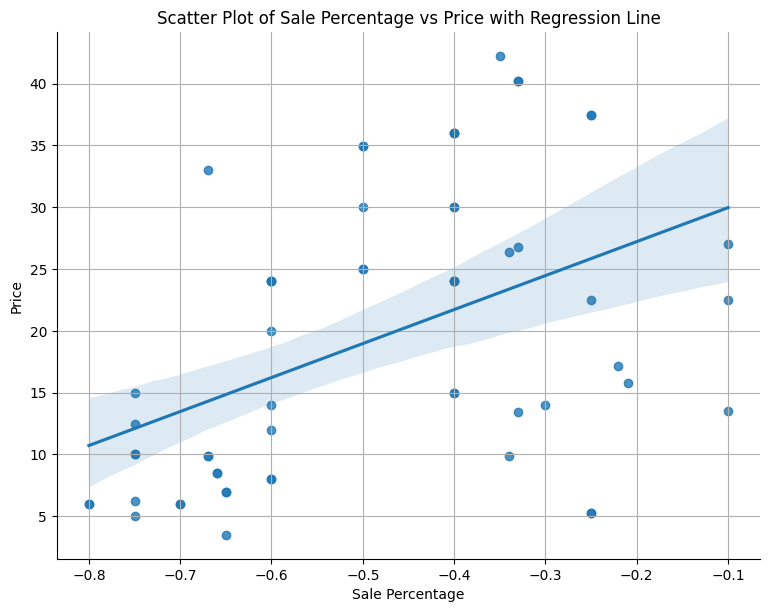

In [106]:
# Calculate the correlation coefficient (optional, but good for context)
# Use regression_df as it contains both 'price' and 'salePercentage' as numeric
correlation = regression_df['salePercentage'].corr(regression_df['price'])
print(f"Correlation between sale percentage and price: {correlation:.2f}")

# Create the scatter plot using seaborn's lmplot to include the regression line
# lmplot creates a FacetGrid, which handles figure and axes internally
sns.lmplot(x="salePercentage", y="price", data=regression_df, height=6, aspect=1.3)
plt.title('Scatter Plot of Sale Percentage vs Price with Regression Line')
plt.xlabel('Sale Percentage')
plt.ylabel('Price')
plt.grid(True) # Add a grid for better readability
plt.show()

because the R^2 value is below 0.5, it means the correlation between 'salepercentage' and 'price' is low.

In [107]:
# KNN Execution
# Importing train_test_split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/3,random_state=42)
from sklearn.neighbors import KNeighborsRegressor

test_scores = []
train_scores = []
for i in range(1,15):
    knn = KNeighborsRegressor(i)
    knn.fit(X_train,y_train)

    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [108]:
# Maximum Training score

max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,
                                               list(map(lambda x: x+1,
                                                        train_scores_ind))))

Max train score 61.16144083638606 % and k = [5]


In [109]:
# Maximum Testing score

max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,
                                              list(map(lambda x: x+1,
                                                       test_scores_ind))))

Max test score 24.28206685039814 % and k = [14]


In [110]:
# Try the model after we got the optimal k

knn = KNeighborsRegressor(14)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.24282066850398143

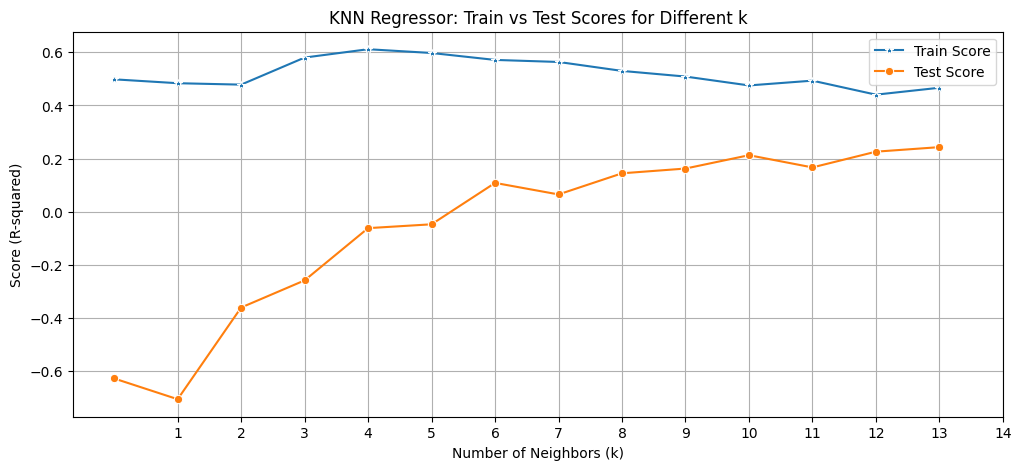

In [111]:
# Visualize the results

plt.figure(figsize=(12,5))
p = sns.lineplot(data=train_scores,marker='*',label='Train Score')
p = sns.lineplot(data=test_scores,marker='o',label='Test Score')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Score (R-squared)")
plt.title("KNN Regressor: Train vs Test Scores for Different k")
plt.xticks(range(1, 15))
plt.legend()
plt.grid(True)
plt.show()

The treaining score generally decreaeses as the number of neighbors or k increases, which led to overfitting. It indicates the KNN Regressor model is overfitting the training data and does not generalize well to unseen data. 'salePercentage' is not a strong predictor of 'price' using a KNN model.